# Data Preparation
This notebook contains all data preparation and preprocessing steps for the yeast ML project.

## 1. Import Libraries

In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer

## 2. Load Dataset

In [5]:
# Load the raw dataset
df = pd.read_csv('yeast.csv')

## 3. Data Cleaning

### 3.1 Feature Selection

In [6]:
# Remove Sequence Name column as it is not needed for analysis
df_before = df.copy()
df = df.drop(columns=['SeqName'])

### 3.2 Handle Duplicates

In [7]:
# Remove duplicate rows
print(f"Dataset shape before removing duplicates and SeqName feature: {df_before.shape}")
df = df.drop_duplicates()
print(f"Dataset shape after removing duplicates: {df.shape}")
print(f"Number of duplicates removed: {df_before.shape[0] - df.shape[0]}")

Dataset shape before removing duplicates and SeqName feature: (1484, 10)
Dataset shape after removing duplicates: (1453, 9)
Number of duplicates removed: 31


### 3.3 Handle Outliers

In [8]:
# Get all features with over 70 outliers and show their classes
outlier_threshold = 70
outlier_features = []
for column in df.select_dtypes(include=[np.number]).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    if len(outliers) > outlier_threshold:
        outlier_features.append(column)
        print(f"Feature '{column}' has {len(outliers)} outliers.")
        print("Classes of outlier rows:")
        print(outliers['ProteinSite'].value_counts())
        print()

Feature 'vac' has 89 outliers.
Classes of outlier rows:
ProteinSite
CYT    31
NUC    24
MIT    10
EXC     9
ME2     5
ME3     4
VAC     3
ME1     2
POX     1
Name: count, dtype: int64

Feature 'nuc' has 133 outliers.
Classes of outlier rows:
ProteinSite
NUC    88
CYT    27
ME3    11
ME1     3
MIT     3
ME2     1
Name: count, dtype: int64



In [9]:
# Handle outliers (removal or transformation)
# Remove outlier instance if its class happens less than 11 times within the outliers
# outlier = [ex1, ex2, ...]
# For each feature in outlier_features:
#   For each outlier in that feature:
#      If class of outlier happens less than 11 times within the outliers of that feature:
#        Remove that outlier from the dataset
for feature in outlier_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    for index, row in outliers.iterrows():
        outlier_count = outliers[outliers['ProteinSite'] == row['ProteinSite']].shape[0]
        if outlier_count < 11:
            df = df.drop(index)

print(f"Dataset shape after removing outliers: {df.shape}")

Dataset shape after removing outliers: (1402, 9)


## 4. Format Data

### 4.1 Feature Transformation

#### 4.1.1 Simulate Transformations on Dataset copy

In [15]:
# Apply transformations (log, sqrt, etc.)
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import numpy as np

df_transformed = df.copy()
# Based on visual validation from EDA and testing, apply specific transformations:
# - mit: Yeo-Johnson (Box-Cox variant that handles negative values)
# - vac: Yeo-Johnson (Box-Cox variant that handles negative values)  
# - nuc: Square root transformation
# - mcg, gvh, alm: Keep original (good distributions)
# - erl, pox: Keep original (categorical )


# 1. Yeo-Johnson transformation for mit and vac
yeo_johnson_features = ['mit', 'vac']
power_transformer = PowerTransformer(method='yeo-johnson')

for feature in yeo_johnson_features:
    if feature in df_transformed.columns:
        # Apply transformation
        feature_data = df_transformed[feature].values.reshape(-1, 1)
        transformed_data = power_transformer.fit_transform(feature_data).flatten()
        
        # Add transformed feature
        df_transformed[feature] = transformed_data
        
        # Calculate improvement
        orig_skew = abs(stats.skew(df[feature]))
        trans_skew = abs(stats.skew(transformed_data))

        print(f"{feature}: Yeo-Johnson aplicado")
        print(f"   Assimetria: {orig_skew:.3f} → {trans_skew:.3f}")

# 2. Square root transformation for nuc
sqrt_features = ['nuc']

for feature in sqrt_features:
    if feature in df.columns:
        # Apply square root transformation
        transformed_data = np.sqrt(df[feature])
        
        # Add transformed feature
        df_transformed[feature] = transformed_data
        
        # Calculate improvement
        orig_skew = abs(stats.skew(df[feature]))
        trans_skew = abs(stats.skew(transformed_data))
        
        print(f"{feature}: Square root aplicado")
        print(f"   Assimetria: {orig_skew:.3f} → {trans_skew:.3f}")

# Summary
print(f"Shape do dataset: {df_transformed.shape}")


mit: Yeo-Johnson aplicado
   Assimetria: 0.102 → 0.000
vac: Yeo-Johnson aplicado
   Assimetria: 0.313 → 0.053
nuc: Square root aplicado
   Assimetria: 1.576 → 0.139
Shape do dataset: (1402, 9)


#### 4.1.2 Distributions Before and After Gaussian Transformations with Q-Q plot

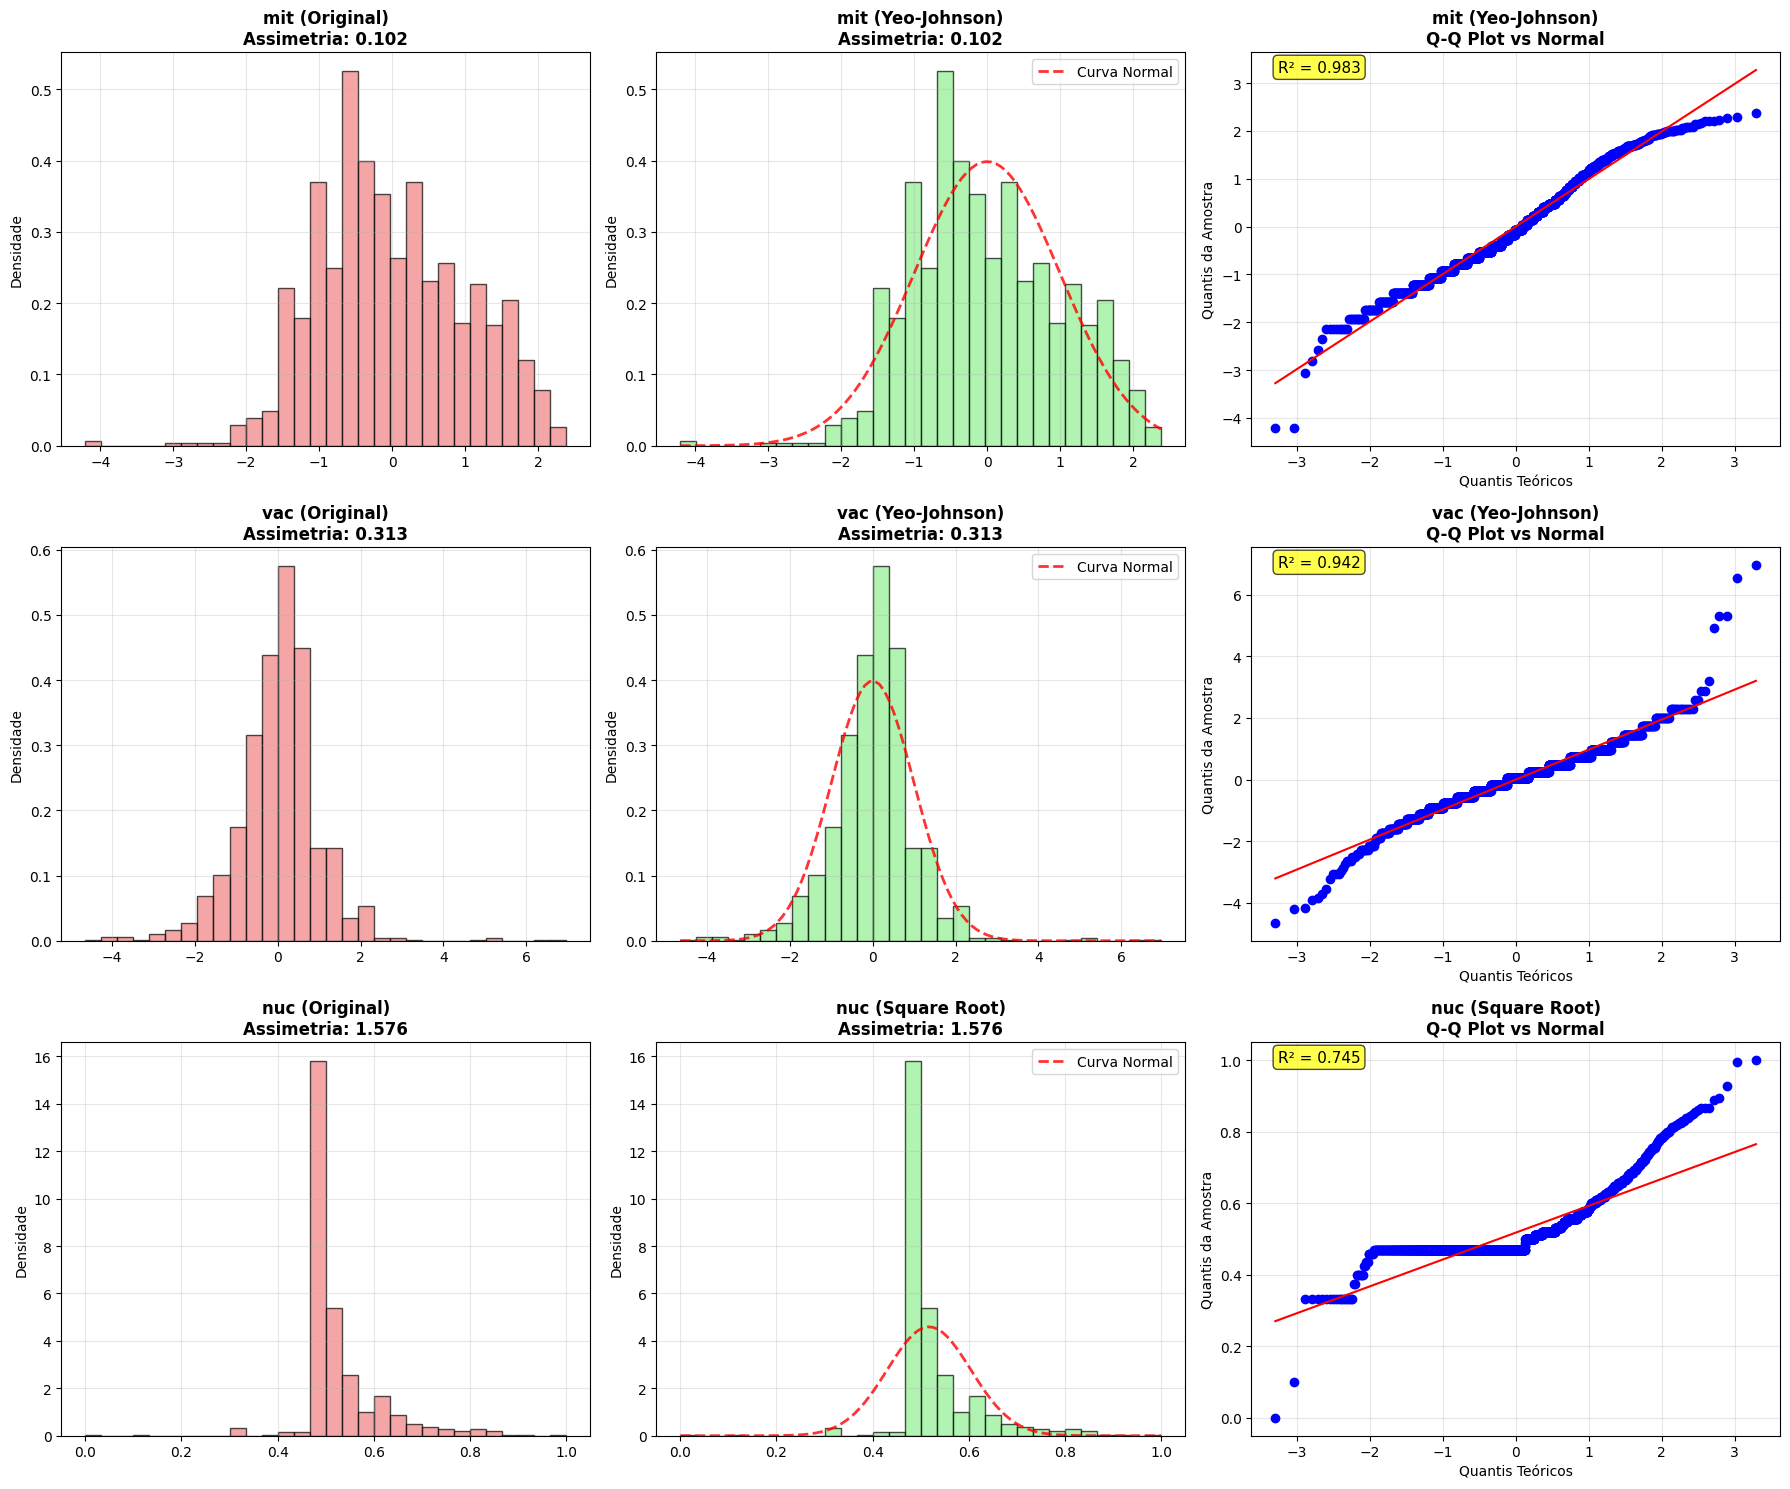

RESUMO DAS TRANSFORMAÇÕES APLICADAS:
Feature  Método          Skew Original   Skew Transformada  R² Q-Q     Melhoria na Assimetria
mit      Yeo-Johnson     1.483           0.102              0.983        93.1%
vac      Yeo-Johnson     1.909           0.313              0.942        83.6%
nuc      Square Root     2.542           1.576              0.745        38.0%


In [11]:
# Verificação visual das transformações aplicadas
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Features and their transformations
transformations = ['mit', 'vac', 'nuc']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

for i, variable in enumerate(transformations):
        
        # Original distribution
        axes[i, 0].hist(df_transformed[variable], bins=30, alpha=0.7, color='lightcoral', 
                       edgecolor='black', density=True)
        orig_skew = stats.skew(df_transformed[variable])
        axes[i, 0].set_title(f'{variable} (Original)\nAssimetria: {orig_skew:.3f}', 
                            fontweight='bold', fontsize=12)
        axes[i, 0].grid(True, alpha=0.3)
        axes[i, 0].set_ylabel('Densidade')
        
        # Transformed distribution
        axes[i, 1].hist(df_transformed[variable], bins=30, alpha=0.7, color='lightgreen', 
                       edgecolor='black', density=True)
        trans_skew = stats.skew(df_transformed[variable])
        method_name = 'Square Root' if variable == 'nuc' else 'Yeo-Johnson'
        axes[i, 1].set_title(f'{variable} ({method_name})\nAssimetria: {trans_skew:.3f}', 
                            fontweight='bold', fontsize=12)
        axes[i, 1].grid(True, alpha=0.3)
        axes[i, 1].set_ylabel('Densidade')
        
        # Add normal curve overlay for transformed data
        x = np.linspace(df_transformed[variable].min(), df_transformed[variable].max(), 100)
        normal_curve = stats.norm.pdf(x, df_transformed[variable].mean(), df_transformed[variable].std())
        axes[i, 1].plot(x, normal_curve, 'r--', linewidth=2, alpha=0.8, label='Curva Normal')
        axes[i, 1].legend()
        
        # Q-Q plot for normality assessment
        probplot_result = probplot(df_transformed[variable], dist="norm", plot=axes[i, 2])
        axes[i, 2].set_title(f'{variable} ({method_name})\nQ-Q Plot vs Normal', 
                           fontweight='bold', fontsize=12)
        axes[i, 2].grid(True, alpha=0.3)
        axes[i, 2].set_xlabel('Quantis Teóricos')
        axes[i, 2].set_ylabel('Quantis da Amostra')
        
        # Calculate R² for Q-Q plot (measure of normality)
        # probplot returns ((osm, osr), (slope, intercept, r))
        theoretical_quantiles = probplot_result[0][0]  # theoretical quantiles
        sample_quantiles = probplot_result[0][1]       # sample quantiles
        r_squared = probplot_result[1][2] ** 2         # r-value squared
        
        axes[i, 2].text(0.05, 0.95, f'R² = {r_squared:.3f}', transform=axes[i, 2].transAxes,
                       fontsize=11, bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

plt.tight_layout()
plt.show()

# Summary table
print("RESUMO DAS TRANSFORMAÇÕES APLICADAS:")
print("=" * 85)
print(f"{'Feature':<8} {'Método':<15} {'Skew Original':<15} {'Skew Transformada':<18} {'R² Q-Q':<10} {'Melhoria na Assimetria'}")
print("=" * 85)

for variable in transformations:
    if variable in df_transformed.columns:
        orig_skew = abs(stats.skew(df[variable]))
        trans_skew = abs(stats.skew(df_transformed[variable]))
        improvement = ((orig_skew - trans_skew) / orig_skew) * 100
        method = 'Square Root' if variable == 'nuc' else 'Yeo-Johnson'

        # Calculate R² for Q-Q plot
        probplot_result = probplot(df_transformed[variable], dist="norm")
        r_squared = probplot_result[1][2] ** 2  # r-value squared from regression

        print(f"{variable:<8} {method:<15} {orig_skew:<15.3f} {trans_skew:<18.3f} {r_squared:<10.3f} {improvement:>6.1f}%")


#### 4.1.3 Applying Transformation to Dataset

In [36]:
# Remove 
df = df_transformed
print(f"Final dataset shape after transformations: {df.shape}")
df.head()

Final dataset shape after transformations: (1402, 9)


,mcg,gvh,alm,mit,erl,pox,vac,nuc,ProteinSite
0,0.58,0.61,0.47,-1.239407,0.5,0.0,-0.549270,0.684866,MIT
1,0.43,0.67,0.48,0.414778,0.5,0.0,0.496288,0.684866,MIT
2,0.64,0.62,0.49,-0.922159,0.5,0.0,0.496288,0.684866,MIT
3,0.58,0.44,0.57,-1.239407,0.5,0.0,0.724616,0.684866,NUC
4,0.42,0.44,0.48,1.701717,0.5,0.0,-0.549270,0.684866,MIT


### 4.2 Normalization

In [39]:
# Dataframe description before normalization
df.describe()

,mcg,gvh,alm,mit,erl,pox,vac,nuc
count,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000,1402.000000
mean,0.496683,0.497703,0.500535,0.665323,0.504993,0.007939,0.434505,0.716850
std,0.134239,0.121706,0.083755,0.145202,0.049732,0.077844,0.087660,0.059882
min,0.110000,0.130000,0.210000,0.000000,0.500000,0.000000,0.000000,0.000000
25%,0.402500,0.420000,0.460000,0.552657,0.500000,0.000000,0.386373,0.684866
50%,0.480000,0.490000,0.510000,0.658675,0.500000,0.000000,0.439692,0.684866
75%,0.570000,0.570000,0.550000,0.768650,0.500000,0.000000,0.477994,0.740083
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.830000,1.000000,1.000000


In [40]:
# Apply standardization (StandardScaler)
df_scaled = df.copy()
# Separate features by scaling strategy based on EDA and transformations
features_to_normalize = ['mit', 'vac', 'nuc'] # Bounded features

scaler_minmax = MinMaxScaler()

# Fit and transform
normalized_data = scaler_minmax.fit_transform(df[features_to_normalize])

# Create new column names for normalized features

# Add normalized features to dataframe
df_scaled[features_to_normalize] = pd.DataFrame(normalized_data, columns=features_to_normalize, index=df.index)


print(f"MinMaxScaler aplicado em {len(features_to_normalize)} features: \n{features_to_normalize}")

# Dataframe head after normalization
df = df_scaled
df.head()

MinMaxScaler aplicado em 3 features: 
['mit', 'vac', 'nuc']


,mcg,gvh,alm,mit,erl,pox,vac,nuc,ProteinSite
0,0.58,0.61,0.47,0.485423,0.5,0.0,0.386373,0.684866,MIT
1,0.43,0.67,0.48,0.725528,0.5,0.0,0.477994,0.684866,MIT
2,0.64,0.62,0.49,0.531471,0.5,0.0,0.477994,0.684866,MIT
3,0.58,0.44,0.57,0.485423,0.5,0.0,0.498002,0.684866,NUC
4,0.42,0.44,0.48,0.912327,0.5,0.0,0.386373,0.684866,MIT


## 5. Train-Test Split

In [41]:
# Split data into training and testing sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

## 6. Save Processed Data

In [42]:
# Save the cleaned and preprocessed data
train_data.to_csv('preprocessed_train.csv', index=False)
test_data.to_csv('preprocessed_test.csv', index=False)

## 7. Summary

### Data preparation summary:
-
-
-